# Filtering telluric feature and adding slit info in VIMOS spectra

VIMOS spectra have residual telluric features. The following routine get rid of the most annoying ones.
The header contains only the information about the slits, but not the extracted sources.
Since sometimes a slit contains more than one object, we add this information to the header from an auxiliary
file which was produced when analyzing the data. This files contains the correct coordinates of the targets
and is the one to be used during the analysis of the spectra with showspectra.


In [1]:
def wavfilter(p0, nscale=3, gain=3.3, bias=0, readnoise=6.7, nsigma=5):
    import numpy as np
    from scipy.signal import medfilt
    pp0 = p0 - bias
    npix = len(pp0)
    # mirror the data to avoid border effects ...
    nmirr=2**(nscale+1)+1
    c = np.zeros((2*nmirr+npix,nscale+1))
    w = np.zeros((npix,nscale))

    c[nmirr:nmirr+npix, 0]=pp0
    c[0:nmirr, 0] = np.flip(pp0[0:nmirr]) 
    c[npix+nmirr:npix+2*nmirr, 0] = np.flip(pp0[npix-nmirr:npix])

    for i in range(1, nscale+1):
        c[:,i] = medfilt(c[:, i-1], 2**(i+1)+1)
    for i in range(0,nscale):
        w[:,i] = c[nmirr:nmirr+npix, i] - c[nmirr:nmirr+npix, i+1]
    bgr = c[nmirr:nmirr+npix, nscale]

    # Anscombe transformed coefficients ..
    readnoise=0.0
    tc=0.5*np.sqrt((c/gain+3./8.+(readnoise/gain)**2)>0.) 
    tw = np.zeros((npix,nscale))
    for i in range(nscale):
        tw[:,i]=tc[nmirr:nmirr+npix,i]-tc[nmirr:nmirr+npix,i+1]
        
    mask = np.isfinite(tw[:,0])
    nind = np.sum(mask)
    
    for i in range(5):
        if nind > 10:
            sig = np.sqrt(np.sum(tw[mask,0]**2)/nind)
            mask = np.abs(tw[:,0]) < (3 * sig)
            nind = np.sum(mask)
    sig=sig/0.975

    # 5-sigma cut
    rr = pp0
    for i in range(nscale):
        mask = np.abs(tw[:,i]) <= nsigma*sig
        rr[mask] -= w[mask,i]
        w[mask,i] = 0

    return rr + bias, bgr


In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import pandas as pd


#vimos = '02'
#quadrant = '4'

catalog = '/DATA-1TB/research/a85/fadda/spectra/VIMOS/A85_VIMOS_data_table.csv'
# Read the file with ID and coordinates of extracted sources
df = pd.read_csv(catalog)
idvimos = np.array(df.id)
ravimos =  np.array(df.RA)
decvimos =  np.array(df.Dec)

for iv in range(1,13):
    print(iv)
    vimos = '{:02d}'.format(iv)
    for iq in range(1,5):
        quadrant = str(iq)
        path = '/DATA-1TB/research/a85/fadda/spectra/VIMOS/MOSA85V'+vimos+'/QUAD'+quadrant+'/'
        file = 'MOSA85V'+vimos+'_MOS_SCIENCE_FLUX_REDUCED'
        try:
            with fits.open(path+file+'.fits') as hdu:
                ima = hdu[0].data
                h = hdu[0].header
            # Take away the background and conserve background median level
            n = len(ima[:,0])
            imac = ima.copy()
            mdbgr = np.zeros(n)
            for j in range(n):
                c0 = ima[j,:]
                fc, mc = wavfilter(c0, nscale=7)
                imac[j,:] = (c0 - mc)/np.median(mc)
                mdbgr[j] = np.median(mc)

            tell = np.median(imac, axis=0)
            # The new spectra will be:
            for j in range(n):
                imac[j,:] = ima[j,:] - tell * mdbgr[j]
    
            pattern = 'V'+vimos+'Q'+quadrant
            idvimos5 = np.array([idv[0:5] for idv in idvimos])
            mask = idvimos5 == pattern
            idvimosM = idvimos[mask]
            ravimosM = ravimos[mask]
            decvimosM = decvimos[mask]

            for i, (idv, rav, decv) in enumerate(zip(idvimosM, ravimosM, decvimosM)):
                parts = idv.split("_")
                slitid = parts[1]
                h['HIERARCH SLIT_{:02d}_ID'.format(i)] = slitid
                h['HIERARCH SLIT_{:02d}_RA'.format(i)] = rav
                h['HIERARCH SLIT_{:02d}_DEC'.format(i)] = decv
    
            # Save new spectrum
            hdu = fits.PrimaryHDU(imac)
            hdu.header.extend(h)
            hdu.writeto(path+file+'_tell.fits',overwrite=True)
        except:
            print('V'+vimos+'Q'+quadrant+' is empty')

1
2
3
4
5
V05Q1 is empty
V05Q4 is empty
6
7
8
9
10
11
12


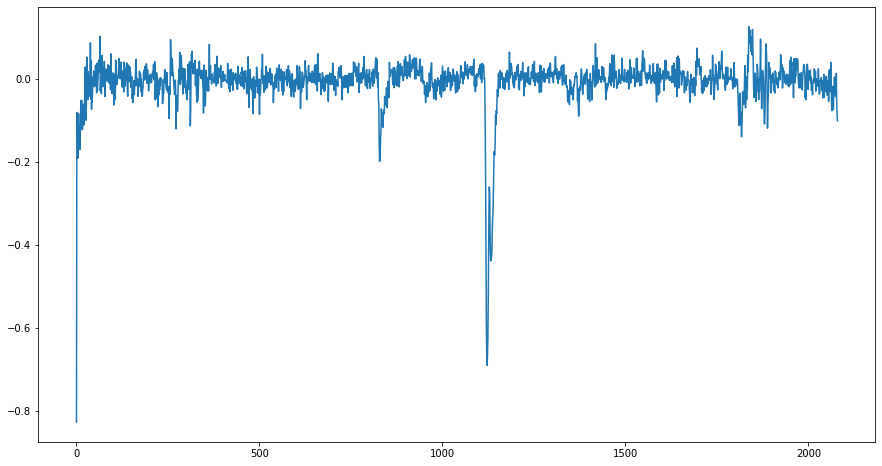

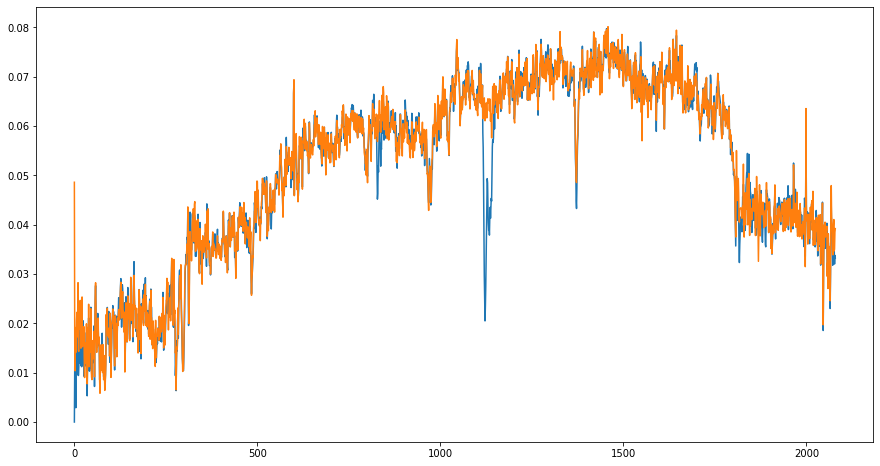

In [3]:
fig=plt.subplots(figsize=(15,8))
plt.plot(tell)
plt.show()

fig=plt.subplots(figsize=(15,8))
plt.plot(ima[1,:])
plt.plot(imac[1,:])
plt.show()